In [1]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

from Forecast import Forecast
from Visualise import Visualise

## Select Dates to Show

In [2]:
# date picker to choose a start date
widg_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime.now(),
                    disabled=False
                )

# date picker to choose an end date
widg_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime.now()+pd.Timedelta('365 days'),
                    disabled=False
                )

freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}

# radio buttons to choose the frequency of dates to display in the table
widg_freq = widgets.RadioButtons(
    options=freq_dict.keys(),
    description='Frequency:',
    disabled=False
)

display(widg_start, widg_end, widg_freq)

DatePicker(value=datetime.datetime(2019, 4, 1, 15, 27, 53, 847411), description='Start Date:')

DatePicker(value=datetime.datetime(2020, 3, 31, 15, 27, 53, 850637), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

## Load Forecast Data

In [3]:
vis = Visualise(pd.to_datetime(widg_start.value), 
                pd.to_datetime(widg_end.value), 
                freq_dict[widg_freq.value])

In [4]:
def update_vis_params(change):
    vis.START_DATE = pd.to_datetime(widg_start.value)
    vis.END_DATE = pd.to_datetime(widg_end.value)
    vis.FREQ = freq_dict[widg_person_freq.value]

widg_start.observe(update_vis_params, names='value')
widg_end.observe(update_vis_params, names='value')
widg_freq.observe(update_vis_params, names='value')

## Rough Equivalents of Martin's Spreadsheet

In [5]:
vis.styled_sheet('person_id')

In [6]:
vis.styled_sheet('project_id')

## Show Someone's Project Assignment

Dropdown(description='Person:', options=('Camila Rangel Smith', 'David Beavan', 'Eric Daub', 'Evelina Gabasova…

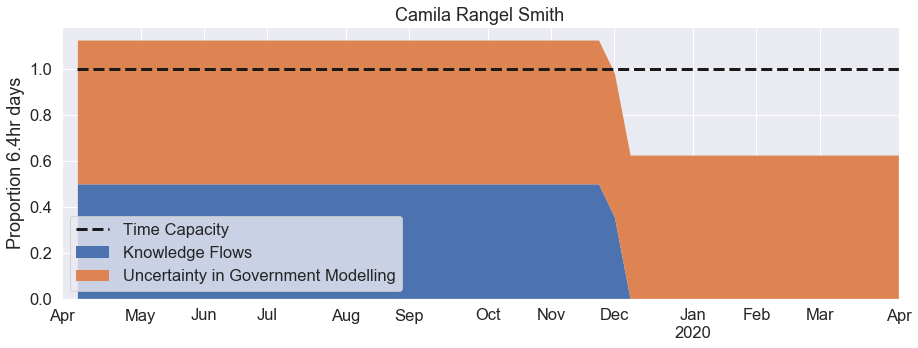

Camila Rangel Smith,Knowledge Flows,Uncertainty in Government Modelling,TOTAL
Apr-2019,50%,62%,112%
May-2019,50%,62%,112%
Jun-2019,50%,62%,112%
Jul-2019,50%,62%,112%
Aug-2019,50%,62%,112%
Sep-2019,50%,62%,112%
Oct-2019,50%,62%,112%
Nov-2019,50%,62%,112%
Dec-2019,0%,62%,62%
Jan-2020,0%,62%,62%


In [7]:
## dropdown list to select a person
widg_person_select = widgets.Dropdown(options=sorted([vis.fc.get_person_name(person_id) for person_id in vis.fc.people.index]),
                                 description='Person:')

def widg_person_select_alloc(change):
    """Function called by widgets to update the person allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_person_select)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    names = widg_person_select.value.split()
    person_id = vis.fc.get_person_id(names[0], ' '.join(names[1:]))
    
    # plot the person allocations
    vis.plot_allocations(person_id, 'person_id')
    
    # print the person allocations table
    display(vis.table_allocations(person_id, 'person_id'))

# setup the event listeners
widg_person_select.observe(widg_person_select_alloc, names='value')

# display the widgets
display(widg_person_select)

# show results with initial values
widg_person_select_alloc(None)

## Show Everyone's Total Project Allocation Over Time

In [8]:
vis.table_allocations('ALL','person_id')

,Camila Rangel Smith,David Beavan,Eric Daub,Evelina Gabasova,Giovanni Colavizza,Jack Roberts,James Geddes,James Hetherington,James Robinson,Jim Madge,Kasra Hosseini,Louise Bowler,Martin O'Reilly,May Yong,Miguel Morin,Nick Barlow,Oliver Strickson,Oscar Giles,Radka Jersakova,Sarah Gibson,Timothy Hobson,Tomas Lazauskas
Apr-2019,112%,100%,0%,162%,75%,0%,50%,25%,100%,50%,0%,112%,0%,50%,162%,100%,62%,0%,100%,50%,100%,50%
May-2019,112%,100%,0%,162%,75%,0%,50%,25%,100%,0%,0%,112%,0%,50%,162%,100%,62%,0%,100%,50%,100%,50%
Jun-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,100%,50%,100%,50%
Jul-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,100%,50%,100%,50%
Aug-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%
Sep-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%
Oct-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%
Nov-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,0%,100%,50%
Dec-2019,62%,100%,0%,162%,75%,0%,0%,25%,94%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,0%,100%,0%
Jan-2020,62%,100%,0%,112%,0%,0%,0%,12%,0%,0%,0%,62%,0%,0%,0%,0%,0%,0%,0%,0%,50%,0%


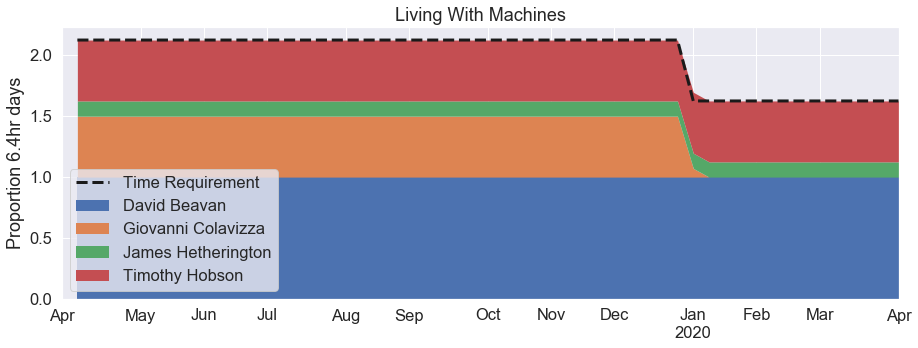

In [9]:
vis.plot_allocations(1823043, 'project_id')

In [14]:
vis.table_allocations(1823043, 'project_id')

Living With Machines,David Beavan,Giovanni Colavizza,James Hetherington,Timothy Hobson
Apr-2019,100%,50%,12%,50%
May-2019,100%,50%,12%,50%
Jun-2019,100%,50%,12%,50%
Jul-2019,100%,50%,12%,50%
Aug-2019,100%,50%,12%,50%
Sep-2019,100%,50%,12%,50%
Oct-2019,100%,50%,12%,50%
Nov-2019,100%,50%,12%,50%
Dec-2019,100%,50%,12%,50%
Jan-2020,100%,0%,12%,50%


In [13]:
vis.table_allocations('ALL_TOTALS','project_id')

id,1723254,1812125,1814107,1823043,1823097,1823098,1823869,1823872,1823898,1823951,1824197,1824209,1824210,1836148,1836162,1846239,1969265,1969338,1969358
Apr-2019,100%,100%,50%,212%,50%,25%,50%,50%,100%,50%,150%,112%,12%,50%,50%,50%,125%,62%,62%
May-2019,100%,100%,50%,212%,0%,25%,50%,50%,100%,50%,150%,112%,12%,50%,50%,50%,125%,62%,62%
Jun-2019,0%,50%,0%,212%,0%,25%,50%,50%,100%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Jul-2019,0%,50%,0%,212%,0%,25%,50%,50%,100%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Aug-2019,0%,50%,0%,212%,0%,25%,50%,50%,50%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Sep-2019,0%,50%,0%,212%,0%,25%,50%,50%,50%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Oct-2019,0%,50%,0%,212%,0%,25%,50%,50%,50%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Nov-2019,0%,50%,0%,212%,0%,25%,50%,50%,0%,50%,150%,0%,12%,50%,50%,50%,62%,62%,62%
Dec-2019,0%,50%,0%,212%,0%,25%,50%,44%,0%,0%,150%,0%,12%,50%,50%,0%,62%,62%,62%
Jan-2020,0%,50%,0%,162%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,62%,62%,62%


In [11]:
# total allocation as a heatmap rather than as a table
df = people_totals.copy()
mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))
df = df[mask].resample('MS').mean()
df.columns = [get_person_name(person_id) for person_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_index(), linewidths=1,
            cmap='Reds', vmin=0, vmax=1.25, cbar=False,
            annot=True, fmt='.0%', annot_kws={'fontsize': 14})

NameError: name 'people_totals' is not defined

## Project Allocations

In [ ]:
df = project_totals.copy()
mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))
df = df[mask].resample('MS').mean()
df = df.loc[:, df.sum()>0]
df.columns = [get_project_name(project_id) for project_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_index(), cmap='Reds', vmax=1.6, linewidths=1, cbar=False,
            annot=True, annot_kws={'fontsize':14}, fmt='.0%')
plt.title('Total Resource Allocation')

In [ ]:
# Project requirements = Project assignments + Resource required assignments
project_reqs = project_totals.copy()

# add resource req info from placeholders
resource_req_ids = placeholders[placeholders.name.str.lower().str.contains('resource required')].index

for idx in resource_req_ids:
    allocs = placeholder_allocations[idx]
    
    for col in allocs.columns:
            project_reqs[col] += allocs[col]
            
            
project_resreq = project_reqs - project_totals

In [ ]:
# project start/end dates
df = project_reqs.copy()
df = df.resample('MS').mean()
df = df.loc[:, df.sum()>0]
df.columns = [get_project_name(project_id) for project_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_values(by=[col for col in df.T.columns],ascending=False), cmap=sns.dark_palette("red"), linewidths=1),#.sort_index(), 
sns.heatmap(df.T.sort_values(by=[col for col in df.T.columns],ascending=False)==0,
            mask=df.T.sort_values(by=[col for col in df.T.columns],ascending=False)!=0,
            cmap=ListedColormap(['whitesmoke']), linewidths=1, cbar=False),#.sort_index(), 

plt.title('Active and Upcoming Projects')

In [ ]:
diff = project_resreq.copy()
reqs = project_reqs.copy()

mask = (diff.index >= pd.to_datetime(widg_team_start.value)) & (diff.index <= pd.to_datetime(widg_team_end.value))
diff = diff[mask].resample('MS').mean()
reqs = reqs[mask].resample('MS').mean()

diff = diff.loc[:, reqs.abs().sum()>0]
reqs = reqs.loc[:, reqs.abs().sum()>0]

diff.columns = [get_project_name(project_id) for project_id in diff.columns]
reqs.columns = [get_project_name(project_id) for project_id in reqs.columns]

diff = pd.DataFrame(diff, index=diff.index.strftime("%b-%Y"))
reqs = pd.DataFrame(reqs, index=reqs.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))

sns.heatmap(diff.T.sort_index(), cmap=ListedColormap(['green', 'orange','orange','orange','red','red', 'red']),linewidths=1, vmin=0,
           mask=reqs.T.sort_index()==0, annot=True,annot_kws={'fontsize':14}, fmt='.1f')


plt.title('Project Resources Required')

In [ ]:
plt.figure(figsize=(15,10))

reqs = project_reqs.sum(axis=1).resample('W-MON').mean()

alloc = project_totals.copy()
alloc = alloc.sum(axis=1).resample('W-MON').mean()

# Weekly capacity just a constant based on number of people for now -
# no way to know e.g. when people started/stopped in REG in current data
team100 = people['weekly_capacity'].sum()

reqs.plot(label='Project Required')
alloc.plot(label='Team Allocated')
xlim=plt.xlim()
plt.plot(plt.xlim(),[team100,team100],'k--',label='Team Total')
plt.xlim(xlim)
plt.legend()
plt.ylabel('FTE (6.4hrs/day)')

To do:

Same views for projects

Include resources from other groups